In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import os
gsl_path = '/apps/spack/anvil/apps/gsl/2.4-gcc-8.4.1-exxsoc2/lib/libgsl.so.23'
os.environ['LD_LIBRARY_PATH'] = f"{gsl_path}:{os.environ.get('LD_LIBRARY_PATH', '')}"
from os.path import join
import numpy as np
import matplotlib as mpl
#mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18



In [3]:

from cmass.lightcone import lc

In [4]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'

In [5]:
# Load observations
from cmass.survey.tools import sky_to_xyz


def load_fits(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)
    return gals


zlim = 0.4, 0.7
fields = ['RA', 'DEC', 'Z', 'WEIGHT_SYSTOT', 'WEIGHT_NOZ', 'WEIGHT_CP']

# Load NGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_North.fits')
cmass = load_fits(fname, fields)
nrdz = cmass[['RA', 'DEC', 'Z']].values
mask = (nrdz[:, 2] > zlim[0]) & (nrdz[:, 2] < zlim[1])
nrdz = nrdz[mask]
nxyz = sky_to_xyz(nrdz, cosmo)

# Load SGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_South.fits')
cmass = load_fits(fname, fields)
srdz = cmass[['RA', 'DEC', 'Z']].values
mask = (srdz[:, 2] > zlim[0]) & (srdz[:, 2] < zlim[1])
srdz = srdz[mask]
sxyz = sky_to_xyz(srdz, cosmo)

print(len(nrdz), len(srdz))

579089 213205


[Text(0.5, 0, 'z'), Text(0, 0.5, 'N')]

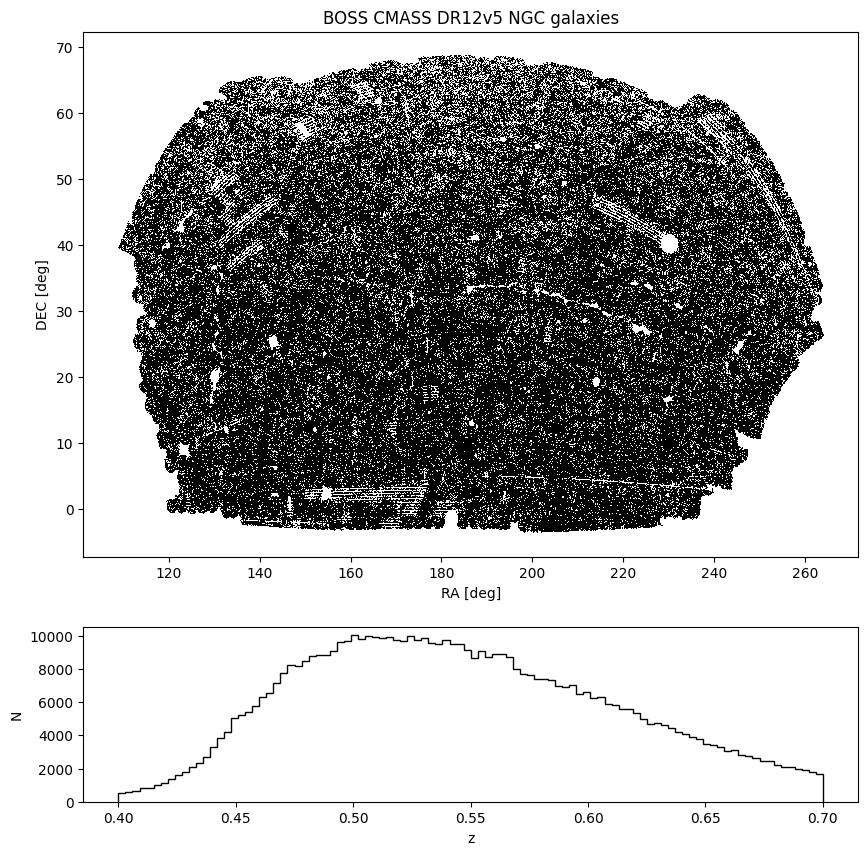

In [6]:
rdz = nrdz

f, axs = plt.subplots(2, 1, figsize=(10, 10),
                      gridspec_kw=dict(height_ratios=[3, 1]))

ax = axs[0]
ax.plot(rdz[:, 0], rdz[:, 1], 'k,', alpha=1)
ax.set(
    xlabel='RA [deg]',
    ylabel='DEC [deg]',
    title='BOSS CMASS DR12v5 NGC galaxies'
)

ax = axs[1]
ax.hist(rdz[:, 2], bins=100, histtype='step', color='k')
ax.set(
    xlabel='z',
    ylabel='N'
)

In [7]:
rdz.shape

(579089, 3)

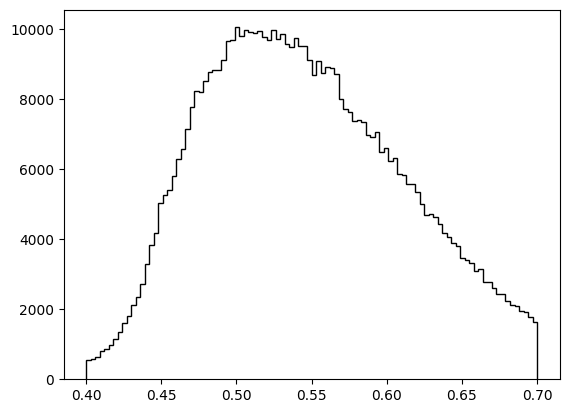

In [8]:
_ = plt.hist(rdz[:, 2], bins=100, histtype='step', color='k')

In [10]:
from cmass.utils import cosmo_to_astropy
from omegaconf import OmegaConf

# Choose simulation
nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384
lhid = 663  # close to fiducial

simpath = join(wdir, nbody, sim, f'L{L}-N{N}', f'{lhid}')

# Load configuration
config = OmegaConf.load(join(simpath, 'config.yaml'))
cosmo = config.nbody.cosmo
asave = config.nbody.asave
Nsnap = len(asave)
print(f'LHID={lhid}\ncosmo={cosmo}\nalist={asave}')

cosmo = cosmo_to_astropy(cosmo)

LHID=663
cosmo=[0.3223, 0.04625, 0.7015, 0.9607, 0.8311]
alist=[0.58622, 0.60633, 0.62644, 0.64655, 0.66666, 0.68677, 0.70688, 0.72699, 0.7471, 0.76721]


In [11]:
# Load halo snapshots
from cmass.bias.apply_hod import load_snapshot

hposs, hvels, hmasses, hmetas = [], [], [], []
for a in tqdm(asave):
    hpos, hvel, hmass, hmeta = load_snapshot(simpath, a)
    hposs.append(hpos), hvels.append(
        hvel), hmasses.append(hmass), hmetas.append(hmeta)

100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


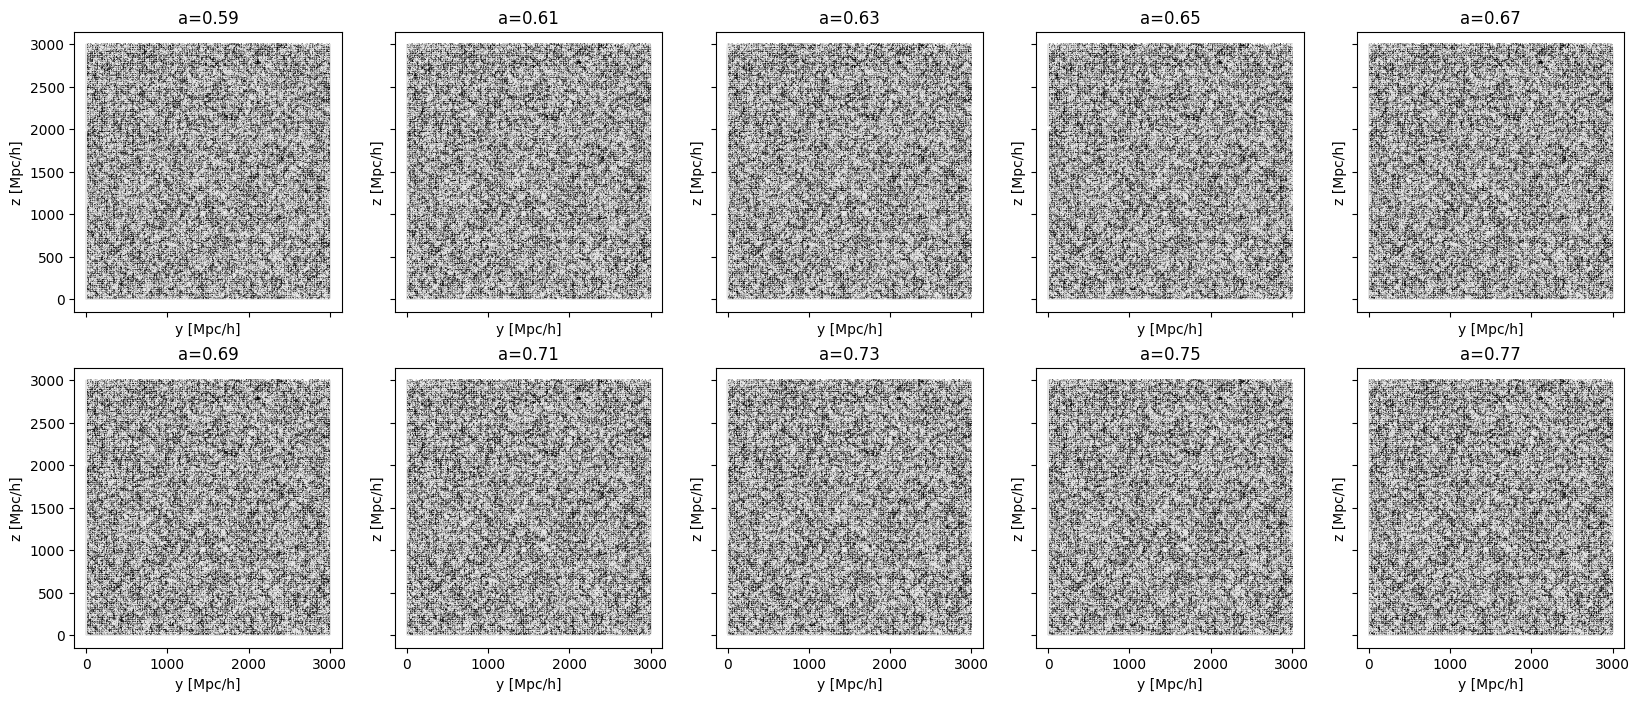

In [12]:
# Plot halos
def plot_slice(xyz, x0, dx, ax, **kwargs):
    mask = (xyz[:, 0] > x0) & (xyz[:, 0] < x0 + dx)
    ax.plot(xyz[mask, 1], xyz[mask, 2], **kwargs)


f, axs = plt.subplots(2, Nsnap//2, figsize=(20, 8), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    plot_slice(hposs[i], 1500, 50, ax, c='k', marker=',', alpha=0.1)
    ax.set(
        xlabel='y [Mpc/h]',
        ylabel='z [Mpc/h]',
        title=f'a={asave[i]:.2f}'
    )

In [13]:
10**-0.5

0.31622776601683794

In [15]:
# apply HOD (cmass.bias.apply_hod)
from cmass.bias.apply_hod import populate_hod

model = 'zheng07'
# theta = dict(
#     logMmin=13.,
#     sigma_logM=0.38,
#     logM0=15.,
#     logM1=15.08,
#     alpha=0.76,
# )
theta = dict(
    logMmin=13.6,
    sigma_logM=0.38,
    logM0=12.6,
    logM1=13.7,
    alpha=1.3,
)
seed = 0

gposs, gvels, gmetas = [], [], []
for i, a in enumerate(asave):
    redshift = (1/a) - 1
    print(f'Applying HOD at a={a:.2f} (z={redshift:.2f})')

    # setup HOD
    hod = populate_hod(
        hposs[i], hvels[i], hmasses[i],
        cosmo, L, redshift,
        model, theta,
        seed=seed,
        hmeta=hmetas[i],  # this stores halo concentration, can also store halo obs redshift # noqa
        mdef='200c'
    )

    # Organize outputs
    gpos = np.array(
        [hod['x'], hod['y'], hod['z']]).T  # comoving positions [Mpc/h]
    gvel = np.array(
        [hod['vx'], hod['vy'], hod['vz']]).T  # physical velocities [km/s]
    gmeta = {'gal_type': hod['gal_type'], 'hostid': hod['halo_id']}

    gposs.append(gpos), gvels.append(gvel), gmetas.append(gmeta)

[11:02:57-INFO] Running populate_hod...
[11:02:57-INFO] Using saved halo concentration...


Applying HOD at a=0.59 (z=0.71)


[11:03:10-INFO] Finished populate_hod... (0m12s)
[11:03:10-INFO] Running populate_hod...
[11:03:10-INFO] Using saved halo concentration...


Applying HOD at a=0.61 (z=0.65)


MemoryError: Unable to allocate 1.58 TiB for an array with shape (434050120034,) and data type float32

In [13]:
# construct lightcone (cmass.survey.lightcone)
# make sure you've built cmass.lightcone first and loaded gsl

from cmass.lightcone import lc

# load mask
boss_dir = '/anvil/scratch/x-mho1/cmass-ili/obs'
maskobs = lc.Mask(boss_dir=boss_dir, veto=True)

# setup lightcone constructor
nz_dir = '/anvil/scratch/x-mho1/cmass-ili/obs/n-z'  # for real BOSS (n(z))
# nz_dir = '/anvil/scratch/x-mho1/cmass-ili/obs/n-z-fake'  # for infinite n(z), no subsample # noqa
snap_times = sorted(asave)[::-1]
lightcone = lc.Lightcone(
    boss_dir=nz_dir,
    mask=maskobs,
    Omega_m=cosmo.Om0,
    zmin=0.4,
    zmax=0.7,
    snap_times=snap_times,
    verbose=True,
    stitch_before_RSD=True,
    augment=0,
    seed=0
)

process_times
interpolate_chi_z
read_boss_nz


In [14]:
from cmass.survey.lightcone import split_galsnap_galidx

for i, a in enumerate(snap_times):
    # Load galaxies
    gpos, gvel = gposs[i], gvels[i]
    hostid = gmetas[i]['hostid']

    # Load halos
    hvel = hvels[i]

    # Get host velocites
    hostvel = hvel[hostid]
    lightcone.add_snap(i, gpos, gvel, hostvel)

# stitch lightcone
ra, dec, z, galid = lightcone.finalize()

# Split galid into galsnap and galidx
galsnap, galidx = split_galsnap_galidx(galid)
grdz = np.array([ra, dec, z]).T

	remap_snapshot
	choose_galaxies
Done with snap index 0
	remap_snapshot
	choose_galaxies
Done with snap index 1
	remap_snapshot
	choose_galaxies
Done with snap index 2
	remap_snapshot
	choose_galaxies
Done with snap index 3
	remap_snapshot
	choose_galaxies
Done with snap index 4
	remap_snapshot
	choose_galaxies
Done with snap index 5
	remap_snapshot
	choose_galaxies
Done with snap index 6
	remap_snapshot
	choose_galaxies
Done with snap index 7
	remap_snapshot
	choose_galaxies
Done with snap index 8


	remap_snapshot
	choose_galaxies
Done with snap index 9
downsample
keep_fraction:
0.11 0.13 0.15 0.19 0.25 0.32 0.40 0.56 0.68 0.79 0.82 0.90 1.05 1.12 1.17 1.14 1.15 1.11 1.14 1.13 1.09 1.02 1.05 1.06 1.07 1.05 0.96 0.94 0.92 0.86 0.77 0.72 0.72 0.68 0.65 0.60 0.59 0.54 0.52 0.45 0.43 0.39 0.36 0.32 0.29 0.27 0.25 0.23 0.20 0.18 0.17 0.16 0.14 
fibcoll
downsample
keep_fraction:
0.88 0.85 0.84 0.87 0.88 0.87 0.90 0.91 0.95 0.95 0.97 0.97 1.03 1.09 1.15 1.13 1.14 1.11 1.13 1.13 1.07 1.01 1.04 1.05 1.05 1.04 0.98 0.97 0.98 0.96 0.96 0.95 0.93 0.94 0.94 0.92 0.93 0.92 0.92 0.91 0.91 0.88 0.89 0.87 0.90 0.87 0.87 0.86 0.87 0.85 0.87 0.84 0.85 


[WARNING] at z=0.4708, do not have enough galaxies, keep_fraction=1.0310
[WARNING] at z=0.4764, do not have enough galaxies, keep_fraction=1.0940
[WARNING] at z=0.4821, do not have enough galaxies, keep_fraction=1.1461
[WARNING] at z=0.4877, do not have enough galaxies, keep_fraction=1.1255
[WARNING] at z=0.4934, do not have enough galaxies, keep_fraction=1.1389
[WARNING] at z=0.4991, do not have enough galaxies, keep_fraction=1.1060
[WARNING] at z=0.5047, do not have enough galaxies, keep_fraction=1.1254
[WARNING] at z=0.5104, do not have enough galaxies, keep_fraction=1.1250
[WARNING] at z=0.5160, do not have enough galaxies, keep_fraction=1.0728
[WARNING] at z=0.5274, do not have enough galaxies, keep_fraction=1.0351
[WARNING] at z=0.5330, do not have enough galaxies, keep_fraction=1.0464
[WARNING] at z=0.5387, do not have enough galaxies, keep_fraction=1.0504
[WARNING] at z=0.5443, do not have enough galaxies, keep_fraction=1.0371


[Text(0.5, 0, 'z'), Text(0, 0.5, 'N')]

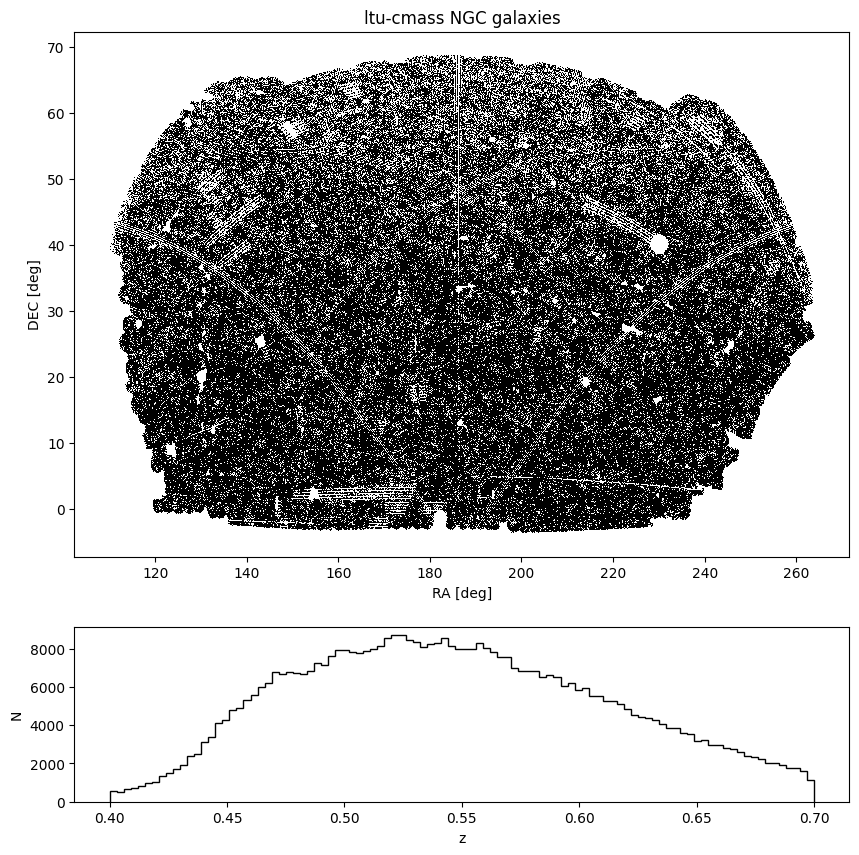

In [15]:
f, axs = plt.subplots(2, 1, figsize=(10, 10),
                      gridspec_kw=dict(height_ratios=[3, 1]))

ax = axs[0]
ax.plot(grdz[:, 0], grdz[:, 1], 'k,', alpha=1)
ax.set(
    xlabel='RA [deg]',
    ylabel='DEC [deg]',
    title='ltu-cmass NGC galaxies'
)

ax = axs[1]
ax.hist(grdz[:, 2], bins=100, histtype='step', color='k')
ax.set(
    xlabel='z',
    ylabel='N'
)

(0.35, 0.75)

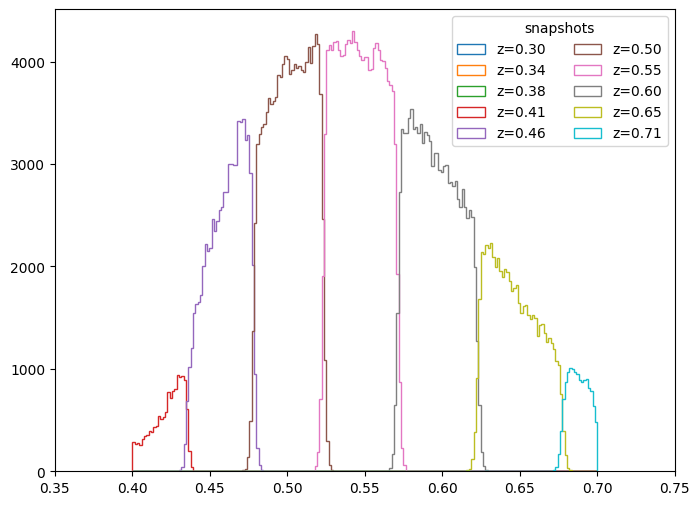

In [16]:
# plot n(z) based on base snapshot
f, ax = plt.subplots(1, 1, figsize=(8, 6))
be = np.linspace(0.4, 0.7, 200)
for i, a in enumerate(snap_times):
    z = (1/a) - 1
    ax.hist(grdz[galsnap == i, 2], bins=be, histtype='step',
            color=f'C{i}', label=f'z={z:.2f}')
ax.legend(ncol=2, title='snapshots')
ax.set_xlim(0.35, 0.75)

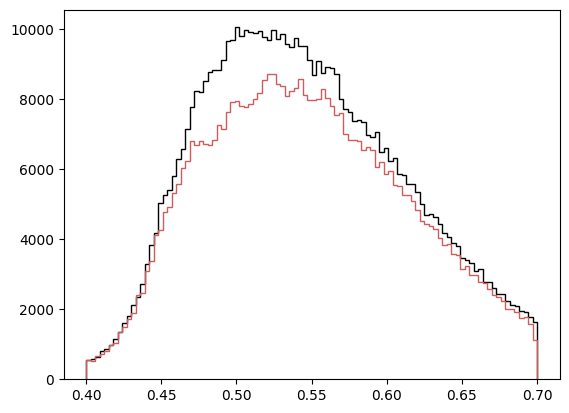

In [17]:

_ = plt.hist(rdz[:, 2], bins=100, histtype='step', color='k')
_ = plt.hist(grdz[:, 2], bins=100, histtype='step', color='indianred')

In [ ]:

from cmass.survey.tools import sky_to_xyz
from astropy.cosmology import Planck18
from cmass.summary.tools import load_randoms
from pycorr import TwoPointCorrelationFunction

In [ ]:

sedges = np.arange(0, 151, 4)
muedges = np.linspace(-1, 1, 241)
edges = (sedges, muedges)


def get_tpcf(rdz, randoms, nthreads=1):

    pos = sky_to_xyz(rdz, Planck18)
    xyz_randoms = sky_to_xyz(randoms, Planck18)
    tpcf = TwoPointCorrelationFunction("smu", edges, data_positions1=pos.T,
                                       randoms_positions1=xyz_randoms.T, los="midpoint", nthreads=nthreads)
    return tpcf

In [ ]:
cmass_tpcf = get_tpcf(rdz[rdz[:, 2] > 0.45], subsampled_randoms)

In [18]:
# Get the halos' positions in redshift space
# this is a bit of a hack, giving each halo one galaxy
# we're keeping all halos, so we know where they go

# setup lightcone constructor
# nz_dir = '/anvil/scratch/x-mho1/cmass-ili/obs/n-z'  # for real BOSS (n(z))
nz_dir = '/anvil/scratch/x-mho1/cmass-ili/obs/n-z-fake'  # for infinite n(z), no subsample # noqa
snap_times = sorted(asave)[::-1]
lightcone = lc.Lightcone(
    boss_dir=nz_dir,
    mask=maskobs,
    Omega_m=cosmo.Om0,
    zmin=0.4,
    zmax=0.7,
    snap_times=snap_times,
    verbose=True,
    stitch_before_RSD=True,
    augment=0,
    seed=0
)

halo_masses = []
for i, a in enumerate(snap_times):
    # Load galaxies
    # inherit the halo positions and velocities
    gpos, gvel, gmass = hposs[i], hvels[i], hmasses[i]
    hostid = np.arange(len(hposs[i]))

    # Get host velocites
    hostvel = gvel
    lightcone.add_snap(i, gpos, gvel, hostvel)
    halo_masses.append(gmass)
# stitch lightcone
ra, dec, z, halid = lightcone.finalize()

# Split galid into galsnap and galidx
halsnap, halidx = split_galsnap_galidx(halid)
hrdz = np.array([ra, dec, z]).T
lightcone_masses = np.array(
    [halo_masses[halsnap[i]][halidx[i]] for i in range(len(hrdz))])

process_times
interpolate_chi_z
read_boss_nz
	remap_snapshot
	choose_galaxies
Done with snap index 0
	remap_snapshot
	choose_galaxies
Done with snap index 1
	remap_snapshot
	choose_galaxies
Done with snap index 2
	remap_snapshot
	choose_galaxies
Done with snap index 3
	remap_snapshot
	choose_galaxies
Done with snap index 4
	remap_snapshot
	choose_galaxies
Done with snap index 5
	remap_snapshot
	choose_galaxies
Done with snap index 6
	remap_snapshot
	choose_galaxies
Done with snap index 7
	remap_snapshot
	choose_galaxies
Done with snap index 8
	remap_snapshot
	choose_galaxies
Done with snap index 9
downsample
keep_fraction:
65.66 64.06 60.96 59.81 57.52 56.77 53.83 56.04 55.64 54.26 53.66 51.03 50.69 50.99 51.13 50.66 48.23 45.62 43.45 43.93 43.69 41.90 39.77 40.56 42.18 42.19 40.96 41.51 41.04 38.81 39.23 37.95 37.39 37.00 37.03 35.79 36.41 35.67 36.31 35.46 35.16 34.65 33.89 32.88 32.56 31.95 31.84 31.51 31.84 31.07 30.80 30.33 30.35 30.12 30.54 35.65 
fibcoll
downsample
keep_fraction

[WARNING] at z=0.4027, do not have enough galaxies, keep_fraction=65.6814
[WARNING] at z=0.4080, do not have enough galaxies, keep_fraction=65.3595
[WARNING] at z=0.4134, do not have enough galaxies, keep_fraction=62.3169
[WARNING] at z=0.4188, do not have enough galaxies, keep_fraction=61.0352
[WARNING] at z=0.4241, do not have enough galaxies, keep_fraction=58.9971
[WARNING] at z=0.4295, do not have enough galaxies, keep_fraction=58.2649
[WARNING] at z=0.4348, do not have enough galaxies, keep_fraction=55.5001
[WARNING] at z=0.4402, do not have enough galaxies, keep_fraction=57.5242
[WARNING] at z=0.4455, do not have enough galaxies, keep_fraction=57.1559
[WARNING] at z=0.4509, do not have enough galaxies, keep_fraction=56.1230
[WARNING] at z=0.4563, do not have enough galaxies, keep_fraction=55.0843
[WARNING] at z=0.4616, do not have enough galaxies, keep_fraction=52.4082
[WARNING] at z=0.4670, do not have enough galaxies, keep_fraction=51.9832
[WARNING] at z=0.4723, do not have eno

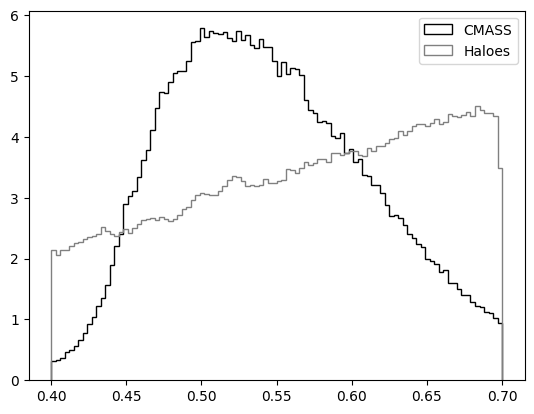

In [19]:

_ = plt.hist(rdz[:, 2], bins=100, histtype='step',
             color='k', density=True, label='CMASS')
# _ = plt.hist(grdz[:, 2], bins=100, histtype='step', color='indianred', density=True,)
_ = plt.hist(hrdz[:, 2], bins=100, histtype='step',
             color='gray', density=True, label='Haloes')
plt.legend()

In [20]:
import numpy as np
from scipy.special import erf


def sample_centrals(log_halo_mass, logMmin=12.0, sigma_logM=0.25,):
    mean_ncen = 0.5 * \
        (1 + erf((log_halo_mass - logMmin) / (np.sqrt(2) * sigma_logM)))
    randoms = np.random.random(len(log_halo_mass))
    centrals_mask = (randoms < mean_ncen).astype(bool)
    return centrals_mask

In [21]:

mask_centrals_constant = sample_centrals(
    lightcone_masses, logMmin=12.8, sigma_logM=0.38,)

In [22]:
def M_i(z, M_i_pivot, mu_i_p, z_pivot, ):
    # + mu_i_p_sq * ((1 / (1 + z)) - (1 / (1 + z_pivot))**2)
    return M_i_pivot + mu_i_p * ((1 / (1 + z)) - (1 / (1 + z_pivot)))


logMmin_z = M_i(hrdz[:, 2], 13.1, -20., 0.61, )
mask_centrals_vary = sample_centrals(
    lightcone_masses, logMmin=logMmin_z, sigma_logM=0.38,)

Text(0.5, 0, 'z')

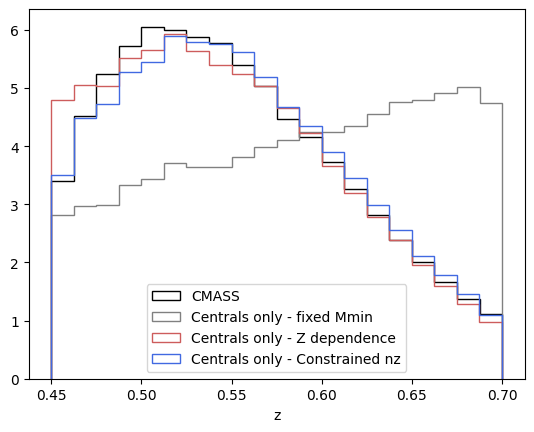

In [73]:
_ = plt.hist(rdz[rdz[:, 2] > 0.45, 2], bins=20, histtype='step',
             color='k', density=True, label='CMASS')
_ = plt.hist(hrdz[(mask_centrals_constant) & (hrdz[:, 2] > 0.45), 2], bins=20,
             histtype='step', color='gray', density=True, label='Centrals only - fixed Mmin')
_ = plt.hist(hrdz[(mask_centrals_vary) & (hrdz[:, 2] > 0.45), 2], bins=20, histtype='step',
             color='indianred', density=True, label='Centrals only - Z dependence')
_ = plt.hist(grdz[(grdz[:, 2] > 0.45), 2], bins=20, histtype='step',
             color='royalblue', density=True, label='Centrals only - Constrained nz')
plt.legend()
plt.xlabel('z')

In [25]:
from astropy.io import fits

randoms = fits.open(
    '/anvil/scratch/x-mho1/cmass-ili/obs/random0_DR12v5_CMASS_North.fits',)

In [26]:
randoms = np.vstack(
    (randoms[1].data['RA'],
     randoms[1].data['DEC'],
     randoms[1].data['Z'],)
).T

In [59]:
indices = np.random.choice(randoms[randoms[:, 2] > 0.45].shape[0], size=len(
    rdz[rdz[:, 2] > 0.45]), replace=False)

subsampled_randoms = randoms[randoms[:, 2] > 0.45][indices]

[Text(0.5, 0, 'z'), Text(0, 0.5, 'N')]

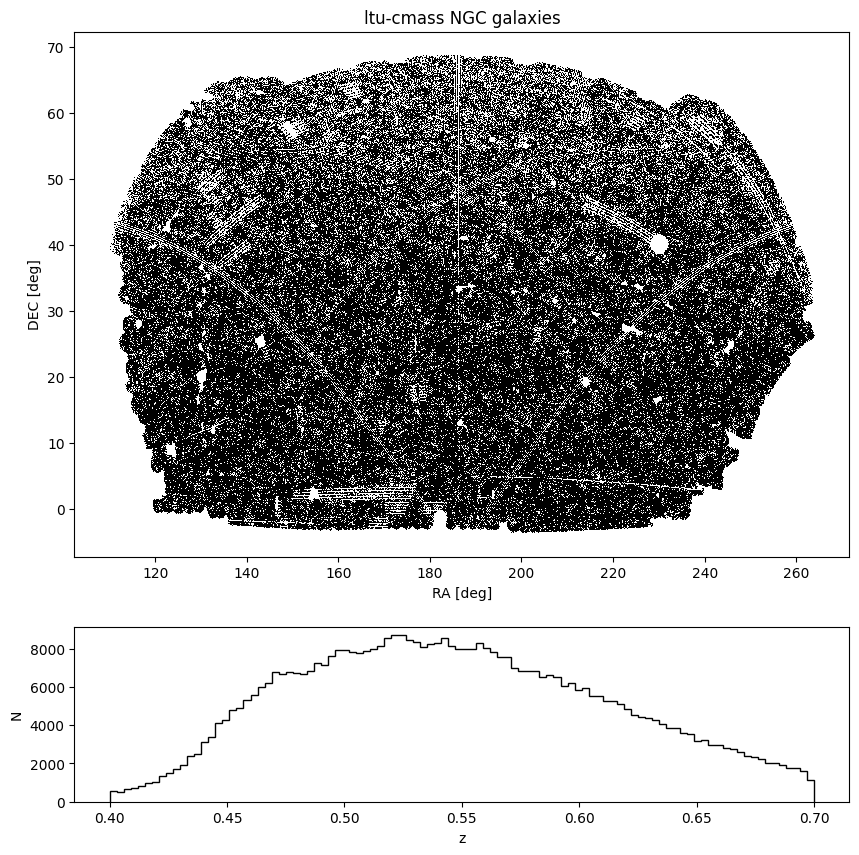

In [49]:
f, axs = plt.subplots(2, 1, figsize=(10, 10),
                      gridspec_kw=dict(height_ratios=[3, 1]))

ax = axs[0]
ax.plot(grdz[:, 0], grdz[:, 1], 'k,', alpha=1)
ax.set(
    xlabel='RA [deg]',
    ylabel='DEC [deg]',
    title='ltu-cmass NGC galaxies'
)

ax = axs[1]
ax.hist(grdz[:, 2], bins=100, histtype='step', color='k')
ax.set(
    xlabel='z',
    ylabel='N'
)

In [60]:
cmass_tpcf = get_tpcf(rdz[rdz[:, 2] > 0.45], subsampled_randoms)

[10:36:09-INFO] Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[10:36:09-INFO] Running auto-correlation.
[10:36:09-INFO] Computing two-point counts D1D2.


pos =  (547008, 3)
xyz randoms =  (547008, 3)


[10:36:22-INFO] Computing two-point counts D1R2.
[10:36:40-INFO] Computing two-point counts R1R2.
[10:36:53-INFO] Correlation function computed in elapsed time 44.04 s.


In [61]:

mock_nz_constrained_tpcf = get_tpcf(
    grdz[(grdz[:, 2] > 0.45)], subsampled_randoms)

[10:37:04-INFO] Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[10:37:04-INFO] Running auto-correlation.
[10:37:04-INFO] Computing two-point counts D1D2.


pos =  (478358, 3)
xyz randoms =  (547008, 3)


[10:37:15-INFO] Computing two-point counts D1R2.
[10:37:31-INFO] Computing two-point counts R1R2.
[10:37:44-INFO] Correlation function computed in elapsed time 39.47 s.


In [69]:
mock_vary_z_tpcf = get_tpcf(
    hrdz[(mask_centrals_vary) & (hrdz[:, 2] > 0.45), :], subsampled_randoms)

[10:56:07-INFO] Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[10:56:07-INFO] Running auto-correlation.
[10:56:07-INFO] Computing two-point counts D1D2.


pos =  (708058, 3)
xyz randoms =  (547008, 3)


[10:56:30-INFO] Computing two-point counts D1R2.
[10:56:55-INFO] Computing two-point counts R1R2.
[10:57:07-INFO] Correlation function computed in elapsed time 60.31 s.


In [70]:

s, cmass_ells = cmass_tpcf(ells=(0, 2), return_sep=True)
s, nz_constrained_ells = mock_nz_constrained_tpcf(ells=(0, 2), return_sep=True)
s, vary_z_ells = mock_vary_z_tpcf(ells=(0, 2), return_sep=True)

In [ ]:
_ = plt.hist(rdz[rdz[:, 2] > 0.45, 2], bins=20, histtype='step',
             color='k', density=True, label='CMASS')
_ = plt.hist(hrdz[(mask_centrals_constant) & (hrdz[:, 2] > 0.45), 2], bins=20,
             histtype='step', color='gray', density=True, label='Centrals only - fixed Mmin')
_ = plt.hist(hrdz[(mask_centrals_vary) & (hrdz[:, 2] > 0.45), 2], bins=20, histtype='step',
             color='indianred', density=True, label='Centrals only - Z dependence')
_ = plt.hist(grdz[(grdz[:, 2] > 0.45), 2], bins=20, histtype='step',
             color='royalblue', density=True, label='Centrals only - Constrained nz')
plt.legend()
plt.xlabel('z')

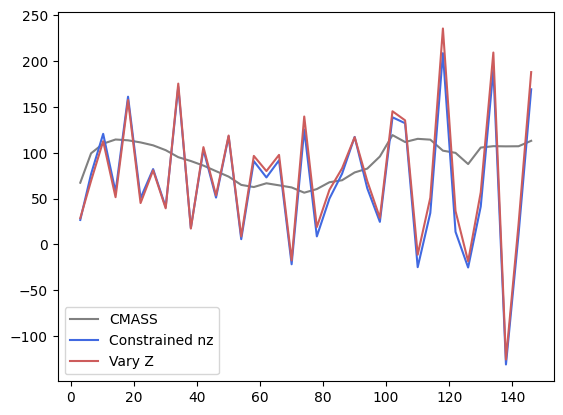

In [76]:
plt.plot(s, s**2*cmass_ells[0], label='CMASS', color='gray')
plt.plot(s, s**2*nz_constrained_ells[0],
         label='Constrained nz', color='royalblue')
plt.plot(s, s**2*vary_z_ells[0], label='Vary Z', color='indianred')
plt.legend()

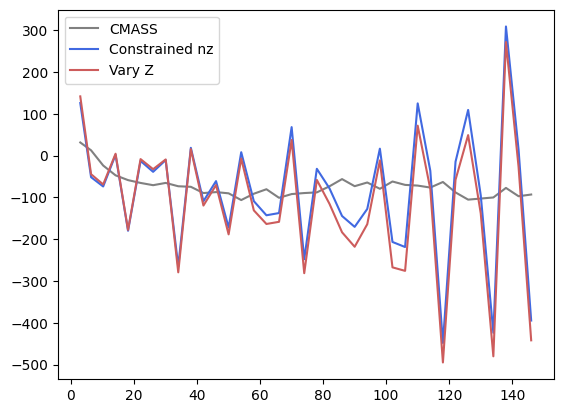

In [77]:
plt.plot(s, s**2*cmass_ells[1], label='CMASS', color='gray')
plt.plot(s, s**2*nz_constrained_ells[1],
         label='Constrained nz', color='royalblue')
plt.plot(s, s**2*vary_z_ells[1], label='Vary Z', color='indianred')
plt.legend()

In [34]:
mock_vary_z_tpcf = get_tpcf(
    hrdz[(mask_centrals_vary) & (hrdz[:, 2] > 0.45), :], subsampled_randoms)

[10:26:32-INFO] Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[10:26:32-INFO] Running auto-correlation.
[10:26:32-INFO] Computing two-point counts D1D2.


pos =  (708058, 3)
xyz randoms =  (547008, 3)


[10:27:17-INFO] Computing two-point counts D1R2.
[10:28:07-INFO] Computing two-point counts R1R2.
[10:28:34-INFO] Correlation function computed in elapsed time 121.90 s.


In [ ]:
mock_tpcf = get_tpcf(
    hrdz[(mask_centrals_constant) & (hrdz[:, 2] > 0.45)],
    randoms[randoms[:, 2] > 0.45],
)

In [ ]:
plt.loglog(
    cmass_tpcf.corr
)

In [ ]:
# how different is their clustering?

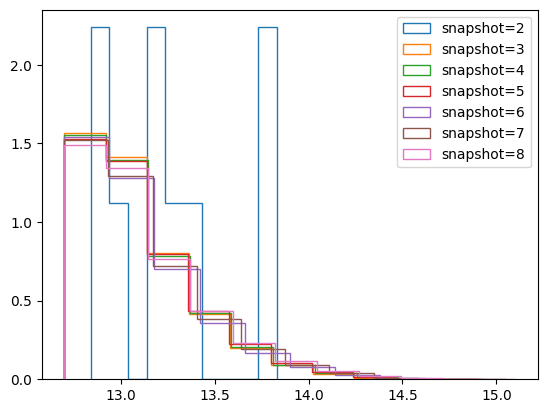

In [83]:
for i in range(2, 9):
    plt.hist(lightcone_masses[halsnap == i],
             histtype='step', density=True, label=f'snapshot={i}')
plt.legend()

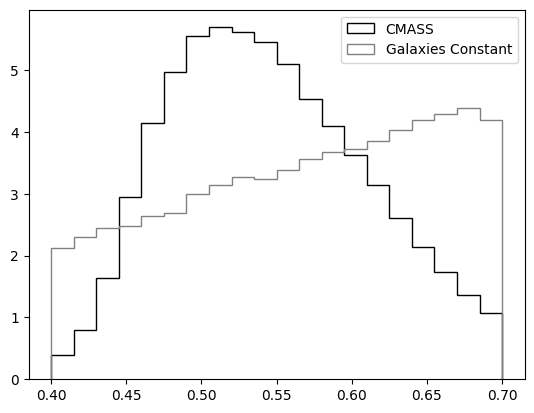

In [87]:

_ = plt.hist(rdz[:, 2], bins=20, histtype='step',
             color='k', density=True, label='CMASS')
# _ = plt.hist(grdz[:, 2], bins=100, histtype='step', color='indianred', density=True,)
_ = plt.hist(hrdz[:, 2], bins=20, histtype='step',
             color='gray', density=True, label='Galaxies Constant')
plt.legend()

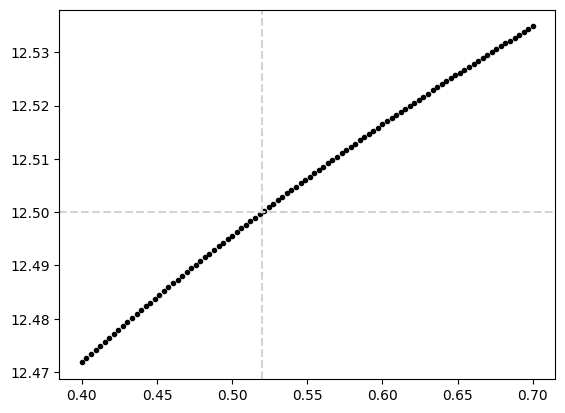

In [32]:
for z in np.linspace(0.4, 0.7, 100):
    plt.plot(z, M_i(z, 12.5, -0.5, 0.52), 'k.')
plt.axhline(12.5, color='lightgray', linestyle='dashed')
plt.axvline(0.52, color='lightgray', linestyle='dashed')

In [203]:
def M_i(z, M_i_pivot, mu_i_p, nu_i_p, z_pivot):
    z_term = ((1 / (1 + z)) - (1 / (1 + z_pivot)))
    return M_i_pivot + mu_i_p * z_term + nu_i_p * z_term**2

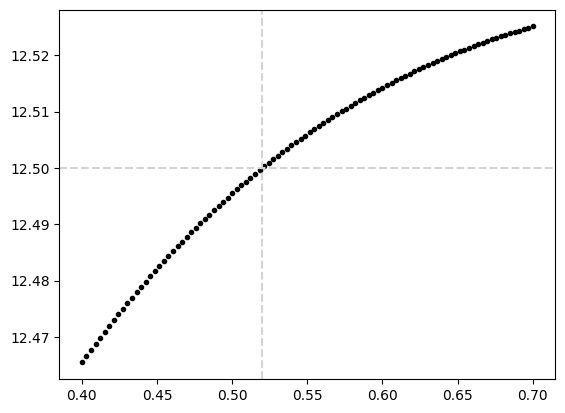

In [204]:
for z in np.linspace(0.4, 0.7, 100):
    plt.plot(z, M_i(z, 12.5, -0.5, -2., 0.52), 'k.')
plt.axhline(12.5, color='lightgray', linestyle='dashed')
plt.axvline(0.52, color='lightgray', linestyle='dashed')